# WatChMaL: MC Dropout Experiments
### Iñaki Erregue Álvarez-Buhilla

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from dictances import bhattacharyya
from sklearn.metrics import *
from utils.utils import *

# 1 - Dropout in Training 

Normal, FC, All, for different dropout rates

In [3]:
base_path = './data/dropout/'

labels = np.load(base_path+'/labels.npy')
test_idxs = np.load(base_path+'/indices.npy')
split_idxs = np.load(base_path+'/IWCD_mPMT_Short_2_class_idxs_xps.npz')

subfolders = [os.path.basename(os.path.normpath(f.path)) for f in os.scandir(base_path) if f.is_dir()]

In [4]:
len(subfolders)

16

In [5]:
data_splitting(split_idxs)

Total num. of events:  2950284
Events for testing: 10.004
Events for validation: 2.399
Events for training: 87.596


In [6]:
results = []
for mode in subfolders:
    results.append(basic_metrics(base_path, labels,mode))

In [7]:
def get_dropout_rates(folder):
    infile = base_path + folder +'/main.log'

    important = []
    keep_phrases = ["fc_dropout", "bb_dropout"]

    with open(infile) as f:
        f = f.readlines()

    for line in f:
        for phrase in keep_phrases:
            if phrase in line:
                important.append(float(re.findall('\d+\.?\d*', line)[0]))
                break

    # first is fc then bb
    return important

In [8]:
pd.set_option("display.precision", 4)
df = pd.DataFrame(results)

df['total_score'] = df.acc+df.f1+df.auc-df.log_loss

df[['fc_dropout', 'bb_dropout']] = df.apply(lambda x: get_dropout_rates(x['model']), axis=1, result_type="expand")

df.sort_values(by='total_score', inplace=True, ascending=False)
df = df[['fc_dropout', 'bb_dropout','log_loss', 'acc', 'f1', 'auc', 'total_score']].reset_index(drop=True)

df.head(len(subfolders))

,fc_dropout,bb_dropout,log_loss,acc,f1,auc,total_score
0,0.1,0.00,0.6062,0.6678,0.6701,0.7312,1.4628
1,0.0,0.00,0.6025,0.6723,0.6438,0.7370,1.4506
2,0.2,0.00,0.6064,0.6689,0.6476,0.7318,1.4419
3,0.3,0.00,0.6071,0.6681,0.6380,0.7321,1.4311
4,0.0,0.05,0.6131,0.6609,0.6607,0.7219,1.4304
5,0.0,0.10,0.6157,0.6587,0.6615,0.7191,1.4236
6,0.1,0.05,0.6149,0.6607,0.6468,0.7200,1.4126
7,0.2,0.05,0.6166,0.6583,0.6295,0.7190,1.3901
8,0.1,0.15,0.6232,0.6521,0.6432,0.7091,1.3812
9,0.3,0.05,0.6212,0.6538,0.6360,0.7119,1.3805


In [9]:
df_groupped = df.groupby(['fc_dropout','bb_dropout']).mean()
df_groupped.sort_values(by='auc', inplace=True, ascending=False)
df_groupped['auc_std'] = df.groupby(['fc_dropout','bb_dropout'])['auc'].std()
df_groupped['xps'] = df.groupby(['fc_dropout','bb_dropout'])['auc'].count()
df_groupped = pd.DataFrame(df_groupped.to_records())
df_groupped

,fc_dropout,bb_dropout,log_loss,acc,f1,auc,total_score,auc_std,xps
0,0.0,0.00,0.6025,0.6723,0.6438,0.7370,1.4506,NaN,1
1,0.3,0.00,0.6071,0.6681,0.6380,0.7321,1.4311,NaN,1
2,0.2,0.00,0.6064,0.6689,0.6476,0.7318,1.4419,NaN,1
3,0.1,0.00,0.6062,0.6678,0.6701,0.7312,1.4628,NaN,1
4,0.0,0.05,0.6131,0.6609,0.6607,0.7219,1.4304,NaN,1
5,0.1,0.05,0.6149,0.6607,0.6468,0.7200,1.4126,NaN,1
6,0.0,0.10,0.6157,0.6587,0.6615,0.7191,1.4236,NaN,1
7,0.2,0.05,0.6166,0.6583,0.6295,0.7190,1.3901,NaN,1
8,0.3,0.05,0.6212,0.6538,0.6360,0.7119,1.3805,NaN,1
9,0.1,0.15,0.6232,0.6521,0.6432,0.7091,1.3812,NaN,1


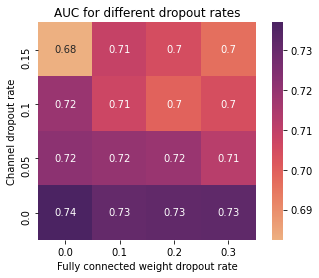

In [11]:
sns.heatmap(pd.pivot_table(df_groupped, values='auc', columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
            annot=True, cmap='flare', square=True) #"ch:s=.25,rot=-.25"
plt.title('AUC for different dropout rates')
plt.xlabel('Fully connected weight dropout rate')
plt.ylabel('Channel dropout rate')
plt.savefig('dropout_heatmap.png', dpi=300, bbox_inches = "tight")
plt.show()

# 2 - MC Dropout

With previous winner, implement different dropout rates and forward passes

In [77]:
predictions = np.load('./data/uncertainties/predictions.npy')

In [78]:
predictions

array([0, 0, 0, ..., 0, 1, 1])

In [79]:
#[total_variance, entropy, mutual_info, margin_confidence, variation_ratio]
uncertainties = np.load('./data/uncertainties/uncertainties.npy')

predictions = np.expand_dims(np.load('./data/uncertainties/predictions.npy'), axis=1)
probs = np.expand_dims(np.load('./data/uncertainties/softmax.npy')[:,1], axis=1)

uncertainties = np.concatenate((uncertainties,probs,predictions,np.expand_dims(labels, axis=1)),axis=1)

In [80]:
uncertainties_df = pd.DataFrame(
    uncertainties, columns=['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio', 'probs', 'pred', 'gt'])

In [89]:
uncertainties_df['pred'] = uncertainties_df['pred'].astype(int)
uncertainties_df['gt'] = uncertainties_df['gt'].astype(int)

# normalize entropy
uncertainties_df['entropy'] = uncertainties_df['entropy']/np.log(2)

uncertainties_df['correct_pred'] = np.where(uncertainties_df['pred'] == uncertainties_df['gt'], 1, 0)

In [90]:
uncertainties_df

,total_variance,entropy,mutual_info,margin_confidence,variation_ratio,probs,pred,gt,correct_pred
0,0.0899,0.8819,0.0181,0.4051,0.0392,0.3005,0,0,1
1,0.1255,0.6920,0.0471,0.6329,0.0196,0.1855,0,0,1
2,0.0922,0.5684,0.0323,0.7319,0.0000,0.1340,0,0,1
3,0.0308,0.9447,0.0020,0.2752,0.0000,0.6376,1,0,0
4,0.0735,0.8946,0.0122,0.3776,0.0000,0.3112,0,0,1
...,...,...,...,...,...,...,...,...,...
295151,0.0297,0.9482,0.0018,0.2665,0.0000,0.6332,1,1,1
295152,0.0150,0.9952,0.0004,0.0817,0.0000,0.5409,1,1,1
295153,0.0407,0.9802,0.0033,0.1676,0.0196,0.4174,0,1,0
295154,0.0251,0.9548,0.0013,0.2489,0.0000,0.6245,1,1,1


In [91]:
def bhattacharyya_d(a: dict, b: dict) -> float:
    """Determine the Bhattacharyya distance beetween the given dictionaries.
    Parameters
    ----------------------------
    a: dict,
        First dictionary to consider.
    b: dict,
        Second dictionary to consider.
    Returns
    ----------------------------
    Return the Bhattacharyya distance beetween the given dictionaries.
    """
    if len(a) > len(b):
        big = a
        small = b
    else:
        big = b
        small= a
    
    total = 0
    for k in small.keys():
        total += np.sqrt(big[k] * small[k])
    
    distance = -np.log(total)
    if np.isinf(distance):
        return 0
    
    return distance

Bhattacharyya distance: 0.3615


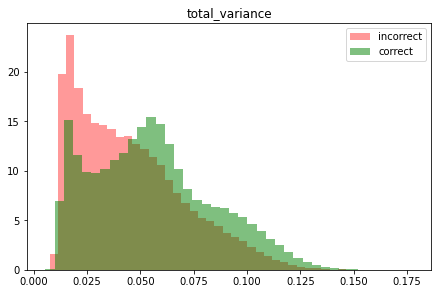

Bhattacharyya distance: 0.3485


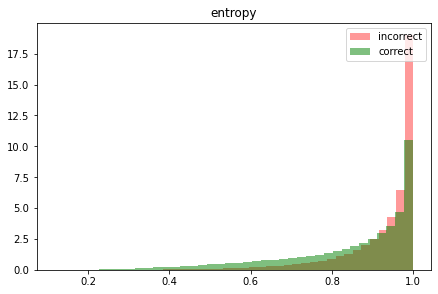

Bhattacharyya distance: 0.2700


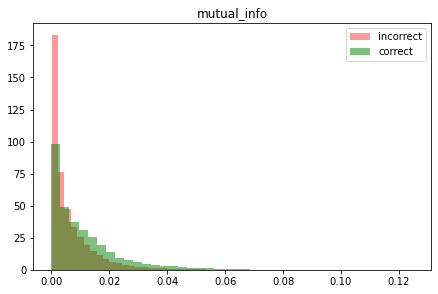

Bhattacharyya distance: 0.3617


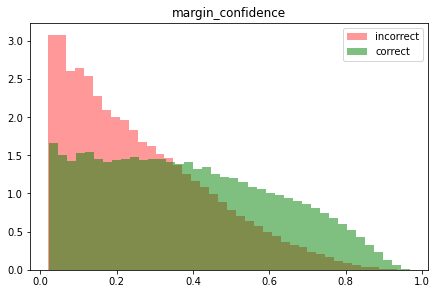

Bhattacharyya distance: 0.0135


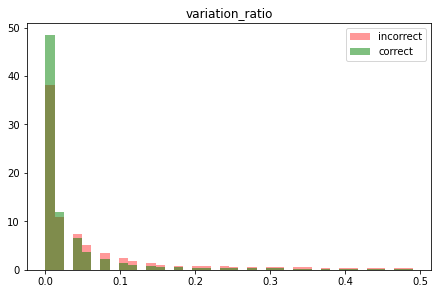

In [96]:

unc_measures = ['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio']
for measure in unc_measures:
    
    correct = uncertainties_df[uncertainties_df['correct_pred'] == 1][measure]
    incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0][measure]
    
    correct_pmf = correct.value_counts(normalize=True)
    incorrect_pmf = incorrect.value_counts(normalize=True)
    
    print('Bhattacharyya distance: %1.4f' % bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict()))

    plt.hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
    plt.hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
    
    plt.legend(loc='upper right')
    plt.title(measure)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()